In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from torchmetrics.classification import MultilabelAccuracy, BinaryAccuracy


plt.style.use("dark_background")

In [38]:
dimension = height, width = 10, 10
red_label = [1, 0, 0]
green_label = [0, 1, 0]
blue_label = [0, 0, 1]

black_channel = np.zeros(dimension)
white_channel = np.ones(dimension) * 255

In [37]:
red_image = np.array([white_channel, black_channel, black_channel])
green_image = np.array([black_channel, white_channel, black_channel])
blue_image = np.array([black_channel, black_channel, white_channel])

In [39]:
n_samples = 300
red_images = [red_image] * n_samples
green_images = [green_image] * n_samples
blue_images = [blue_image] * n_samples

red_labels = [red_label] * n_samples
green_labels = [green_label] * n_samples
blue_labels = [blue_label] * n_samples

images = torch.tensor(
    np.vstack([red_images, green_images, blue_images]) / 255.0,
    dtype=torch.float,
)
labels = torch.tensor(
    np.vstack([red_labels, green_labels, blue_labels]),
    dtype=torch.float,
)

print(images.shape, images.dtype)
print(labels.shape, labels.dtype)

dataset = TensorDataset(images, labels)

torch.Size([900, 3, 10, 10]) torch.float32
torch.Size([900, 3]) torch.float32


In [40]:
class RGBClassifier(nn.Module):
    def __init__(self, dimension, n_channels=3):
        super().__init__()
        height, width = dimension
        self.n_channels = n_channels
        self.dimension = dimension
        self.height = height
        self.width = width
        
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_channels * height * width, 3),
            nn.Sigmoid(),
        )
    
    def forward(self, X):
        return self.model(X)
    
    def predict(self, X):
        with torch.no_grad():
            return self.model(X).detach()

Epochs 1/20: Loss = 0.684061
Epochs 2/20: Loss = 0.447273
Epochs 3/20: Loss = 0.205787
Epochs 4/20: Loss = 0.079797
Epochs 5/20: Loss = 0.030593
Epochs 6/20: Loss = 0.012431
Epochs 7/20: Loss = 0.005460
Epochs 8/20: Loss = 0.002595
Epochs 9/20: Loss = 0.001328
Epochs 10/20: Loss = 0.000727
Epochs 11/20: Loss = 0.000424
Epochs 12/20: Loss = 0.000261
Epochs 13/20: Loss = 0.000169
Epochs 14/20: Loss = 0.000114
Epochs 15/20: Loss = 0.000080
Epochs 16/20: Loss = 0.000058
Epochs 17/20: Loss = 0.000044
Epochs 18/20: Loss = 0.000034
Epochs 19/20: Loss = 0.000027
Epochs 20/20: Loss = 0.000022


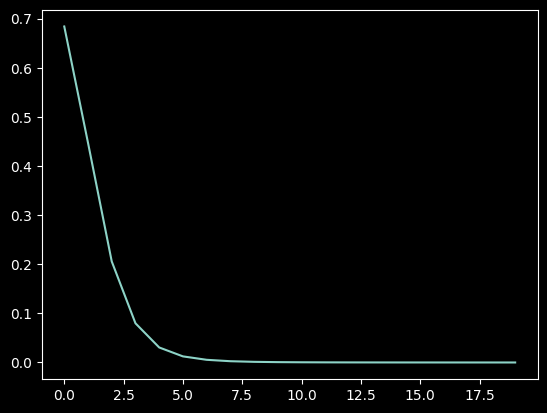

In [56]:
rgb_classifier = RGBClassifier(dimension)

lr = 0.1
epochs = 20
batch_size = len(dataset)

criterion = nn.BCELoss()
optimizer = optim.SGD(rgb_classifier.parameters(), lr=lr, momentum=0.9)

losses = []
dataloader = DataLoader(dataset, batch_size=batch_size)
for epoch in range(1, epochs + 1):
    total_loss = 0
    for X, y in dataloader:
        yhat = rgb_classifier(X)
        loss = criterion(yhat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    total_loss /= len(dataloader)
    
    losses.append(total_loss)
    print(f"Epochs {epoch}/{epochs}: Loss = {total_loss:,.6f}")
    

plt.plot(losses)

In [57]:
bce_metric = MultilabelAccuracy(num_labels=3, threshold=0.5)
y_pred = rgb_classifier.predict(images)
accuracy = bce_metric(y_pred, labels)
print(f"The accuracy is {accuracy:.2%}")

The accuracy is 100.00%


In [58]:
weights = rgb_classifier.state_dict()['model.1.weight']
neuron1 = weights[0].reshape(3, 10, 10)
neuron2 = weights[1].reshape(3, 10, 10)
neuron3 = weights[2].reshape(3, 10, 10)

print((images[0] * neuron1).sum())
print((images[0] * neuron2).sum())
print((images[0] * neuron3).sum())

tensor(10.2015)
tensor(-11.4232)
tensor(-10.7631)


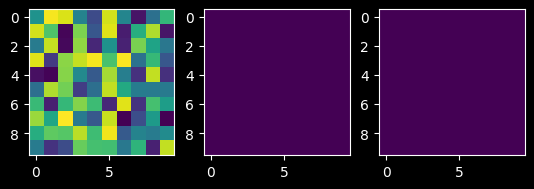

In [59]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3)

ax0.imshow(torch.relu(neuron1[0]))
ax1.imshow(torch.relu(neuron1[1]))
ax2.imshow(torch.relu(neuron1[2]))

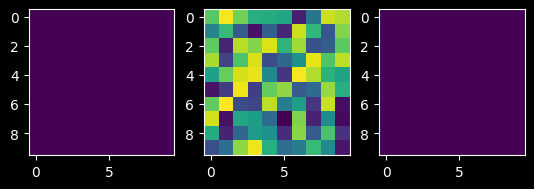

In [60]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3)

ax0.imshow(torch.relu(neuron2[0]))
ax1.imshow(torch.relu(neuron2[1]))
ax2.imshow(torch.relu(neuron2[2]))

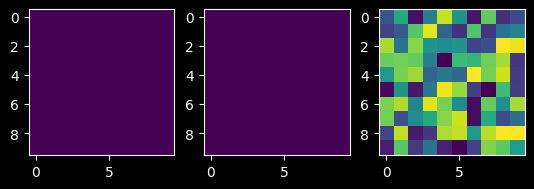

In [61]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3)

ax0.imshow(torch.relu(neuron3[0]))
ax1.imshow(torch.relu(neuron3[1]))
ax2.imshow(torch.relu(neuron3[2]))

In [84]:
rgb_classifier.predict(
    torch.tensor([[white_channel, black_channel, white_channel]], dtype=torch.float) / 255.0
)

tensor([[2.8134e-01, 9.5948e-11, 6.1135e-01]])